we start with 3204769 transcripts, all transcripts were assigned to one of the polygons
from xenium we know that they detected 216323 cells, we detected 167780  or 107806 after processing (including filtering of 26272, because polygon was not uniquely mapped to a cell)

In [5]:
import sys
sys.path.append('utils')
import os
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata
import geopandas as gpd

from stardist.models import StarDist2D

from tifffile import imread, imwrite
from csbdeep.utils import normalize
from shapely.geometry import Polygon, Point
from scipy import sparse
from matplotlib.colors import ListedColormap

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


2024-08-30 11:55:31.546707: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
gdf = gpd.read_file('../data/xenium/voronoi.geojson')
gdf['id'] = [f"ID_{i+1}" for i, _ in enumerate(gdf.index)]
gdf.crs = None
gdf

geometry         id
0       POLYGON ((2211.483 192.669, 2226.350 197.450, ...       ID_1
1       POLYGON ((3134.631 2905.938, 3113.748 2919.271...       ID_2
2       POLYGON ((3009.974 3227.427, 2825.385 3275.559...       ID_3
3       POLYGON ((3069.171 3396.285, 2868.941 3644.323...       ID_4
4       POLYGON ((3013.245 3251.478, 2980.023 3381.020...       ID_5
...                                                   ...        ...
216318  POLYGON ((27881.089 21559.504, 27909.219 21602...  ID_216319
216319  POLYGON ((28922.308 21240.856, 28921.149 21243...  ID_216320
216320  POLYGON ((27628.111 21075.787, 27651.261 20983...  ID_216321
216321  POLYGON ((28855.350 20799.554, 28844.745 20824...  ID_216322
216322  POLYGON ((28666.644 22010.556, 28757.955 21970...  ID_216323

[216323 rows x 2 columns]

In [7]:

import scanpy as sc
adata = sc.read_h5ad('../data/xenium/outs/transcripts_anndata_final.h5ad')
adata

AnnData object with n_obs × n_vars = 3204769 × 541
    obs: 'sample', 'start_x', 'start_y', 'end_x', 'end_y', 'center_x', 'center_y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'end_x', 'end_y', 'spatial', 'start_x', 'start_y'

In [8]:
adata_df = adata.to_df()

In [9]:
df_tissue_positions = adata_df
df_tissue_positions['index'] = df_tissue_positions.index

In [10]:
# Create a GeoDataFrame from the DataFrame of coordinates
geometry = [Point(xy) for xy in zip(adata.obs['center_x'], adata.obs['center_y'])]
gdf_coordinates = gpd.GeoDataFrame(df_tissue_positions, geometry=geometry)

In [11]:
gdf.crs = None

In [12]:
result_spatial_join = gpd.sjoin(gdf_coordinates, gdf, how='left', predicate='within')

In [13]:
# Identify nuclei associated barcodes and find barcodes that are in more than one nucleus
result_spatial_join['is_within_polygon'] = ~result_spatial_join['index_right'].isna()

In [14]:
# Remove barcodes in overlapping nuclei
barcodes_in_one_polygon = result_spatial_join[result_spatial_join['is_within_polygon']==True]


In [15]:
barcodes_in_one_polygon.shape

(3204769, 546)

In [16]:
# Convert the tuples in barcodes_in_one_polygon['index'] to strings
barcodes_in_one_polygon['index'] = barcodes_in_one_polygon['index'].apply(lambda x: str(x))

# If you want to remove the 'bin' index name and set it as a regular column
barcodes_in_one_polygon.reset_index(inplace=True, drop=True)

In [17]:
barcodes_in_overlaping_polygons = pd.unique(result_spatial_join[result_spatial_join.duplicated(subset=['index'])]['index'])
result_spatial_join['is_not_in_an_polygon_overlap'] = ~result_spatial_join['index'].isin(barcodes_in_overlaping_polygons)

# Remove barcodes in overlapping nuclei
barcodes_in_one_polygon = result_spatial_join[result_spatial_join['is_within_polygon'] & result_spatial_join['is_not_in_an_polygon_overlap']]

In [18]:
# The AnnData object is filtered to only contain the barcodes that are in non-overlapping polygon regions
filtered_obs_mask = adata.obs_names.isin(barcodes_in_one_polygon['index'])

In [19]:
filtered_adata = adata[filtered_obs_mask,:]

In [20]:
filtered_adata

View of AnnData object with n_obs × n_vars = 3204769 × 541
    obs: 'sample', 'start_x', 'start_y', 'end_x', 'end_y', 'center_x', 'center_y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'end_x', 'end_y', 'spatial', 'start_x', 'start_y'

In [21]:
print(f"Length of filtered_adata.obs: {len(filtered_adata.obs)}")
print(f"Length of barcodes_in_one_polygon: {len(barcodes_in_one_polygon)}")

Length of filtered_adata.obs: 3204769
Length of barcodes_in_one_polygon: 3204769


In [22]:
print(filtered_adata.obs.index[:5])  # Print first few indices from filtered_adata.obs
print(barcodes_in_one_polygon['index'][:5])  # Print first few indices from barcodes_in_one_polygon

Index(['(0, 1376)', '(0, 1400)', '(0, 1402)', '(0, 1415)', '(0, 1425)'], dtype='object', name='bin')
bin
(0, 1376)    (0, 1376)
(0, 1400)    (0, 1400)
(0, 1402)    (0, 1402)
(0, 1415)    (0, 1415)
(0, 1425)    (0, 1425)
Name: index, dtype: object


In [23]:

# Add the results of the point spatial join to the Anndata object
filtered_adata.obs =  pd.merge(filtered_adata.obs, barcodes_in_one_polygon[['index','geometry', 'id', 'is_within_polygon','is_not_in_an_polygon_overlap']], left_index=True, right_index=True)


In [24]:
filtered_adata.obs

sample       start_x       start_y         end_x         end_y   
bin                                                                            
(0, 1376)    sample1   5977.914968  19691.259132   5987.326733  19700.670896  \
(0, 1400)    sample1   5977.914968  19917.141485   5987.326733  19926.553249   
(0, 1402)    sample1   5977.914968  19935.965014   5987.326733  19945.376779   
(0, 1415)    sample1   5977.914968  20058.317955   5987.326733  20067.729720   
(0, 1425)    sample1   5977.914968  20152.435602   5987.326733  20161.847367   
...              ...           ...           ...           ...           ...   
(2201, 146)  sample1  26693.209086   8114.788543  26702.620851   8124.200308   
(2201, 147)  sample1  26693.209086   8124.200308  26702.620851   8133.612073   
(2201, 148)  sample1  26693.209086   8133.612073  26702.620851   8143.023838   
(2201, 153)  sample1  26693.209086   8180.670896  26702.620851   8190.082661   
(2201, 154)  sample1  26693.209086   8190.082661  26702.620851   8199.494426   

                 center_x      center_y  n_genes_by_counts   
bin                                                          
(0, 1376)     5982.620851  19695.965014                  1  \
(0, 1400)     5982.620851  19921.847367                  1   
(0, 1402)     5982.620851  19940.670896                  2   
(0, 1415)     5982.620851  20063.023838                  1   
(0, 1425)     5982.620851  20157.141485                  1   
...                   ...           ...                ...   
(2201, 146)  26697.914968   8119.494426                  2   
(2201, 147)  26697.914968   8128.906190                  1   
(2201, 148)  26697.914968   8138.317955                  1   
(2201, 153)  26697.914968   8185.376779                  1   
(2201, 154)  26697.914968   8194.788543                  1   

             log1p_n_genes_by_counts  total_counts  log1p_total_counts   
bin                                                                      
(0, 1376)                   0.693147             1            0.693147  \
(0, 1400)                   0.693147             1            0.693147   
(0, 1402)                   1.098612             2            1.098612   
(0, 1415)                   0.693147             1            0.693147   
(0, 1425)                   0.693147             1            0.693147   
...                              ...           ...                 ...   
(2201, 146)                 1.098612             2            1.098612   
(2201, 147)                 0.693147             1            0.693147   
(2201, 148)                 0.693147             1            0.693147   
(2201, 153)                 0.693147             1            0.693147   
(2201, 154)                 0.693147             1            0.693147   

             pct_counts_in_top_50_genes  pct_counts_in_top_100_genes   
bin                                                                    
(0, 1376)                         100.0                        100.0  \
(0, 1400)                         100.0                        100.0   
(0, 1402)                         100.0                        100.0   
(0, 1415)                         100.0                        100.0   
(0, 1425)                         100.0                        100.0   
...                                 ...                          ...   
(2201, 146)                       100.0                        100.0   
(2201, 147)                       100.0                        100.0   
(2201, 148)                       100.0                        100.0   
(2201, 153)                       100.0                        100.0   
(2201, 154)                       100.0                        100.0   

             pct_counts_in_top_200_genes  pct_counts_in_top_500_genes   
bin                                                                     
(0, 1376)                          100.0                        100.0  \
(0, 1400)                          100.0       

In [25]:
# Group the data by unique nucleous IDs
groupby_object = filtered_adata.obs.groupby(['id'], observed=True)

In [26]:
# Extract the gene expression counts from the AnnData object
counts = filtered_adata.X

# Obtain the number of unique nuclei and the number of genes in the expression data
N_groups = groupby_object.ngroups
N_genes = counts.shape[1]

# Initialize a sparse matrix to store the summed gene counts for each nucleus
summed_counts = sparse.lil_matrix((N_groups, N_genes))

# Lists to store the IDs of polygons and the current row index
polygon_id = []
row = 0

# Iterate over each unique polygon to calculate the sum of gene counts.
for polygons, idx_ in groupby_object.indices.items():
    summed_counts[row] = counts[idx_].sum(0)
    row += 1
    polygon_id.append(polygons)

# Create and AnnData object from the summed count matrix
summed_counts = summed_counts.tocsr()
grouped_filtered_adata = anndata.AnnData(X=summed_counts,obs=pd.DataFrame(polygon_id,columns=['id'],index=polygon_id),var=filtered_adata.var)

%store grouped_filtered_adata


Stored 'grouped_filtered_adata' (AnnData)


In [27]:
grouped_filtered_adata

AnnData object with n_obs × n_vars = 152117 × 541
    obs: 'id'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [28]:
# Create a mask based on the 'id' column for values present in 'gdf' with 'area' less than 500
#mask_area = grouped_filtered_adata.obs['id'].isin(gdf[(gdf['area'] < 3000)].id)

# Create a mask based on the 'total_counts' column for values greater than 100
#ask_count = grouped_filtered_adata.obs['total_counts'] > 100

# Apply both masks to the original AnnData to create a new filtered AnnData object
count_area_filtered_adata = grouped_filtered_adata

# Calculate quality control metrics for the filtered AnnData object
sc.pp.calculate_qc_metrics(count_area_filtered_adata, inplace=True)


In [29]:
 # Normalize total counts for each cell in the AnnData object
sc.pp.normalize_total(count_area_filtered_adata, inplace=True)

# Logarithmize the values in the AnnData object after normalization
sc.pp.log1p(count_area_filtered_adata)

# Identify highly variable genes in the dataset using the Seurat method
sc.pp.highly_variable_genes(count_area_filtered_adata, flavor="seurat", n_top_genes=2000)

# Perform Principal Component Analysis (PCA) on the AnnData object
sc.pp.pca(count_area_filtered_adata)

# Build a neighborhood graph based on PCA components
sc.pp.neighbors(count_area_filtered_adata)

# Perform Leiden clustering on the neighborhood graph and store the results in 'clusters' column

# Adjust the resolution parameter as needed for different samples
#sc.tl.leiden(count_area_filtered_adata, resolution=0.4, key_added="clusters")


_index.py (146): Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


In [30]:
sc.tl.leiden(count_area_filtered_adata, resolution=0.4, key_added="clusters")

1979648850.py (1): In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.


In [31]:
import imageio

# Load the image
img = imageio.imread('../data/xenium/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.ome.tif')

268951726.py (4): Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


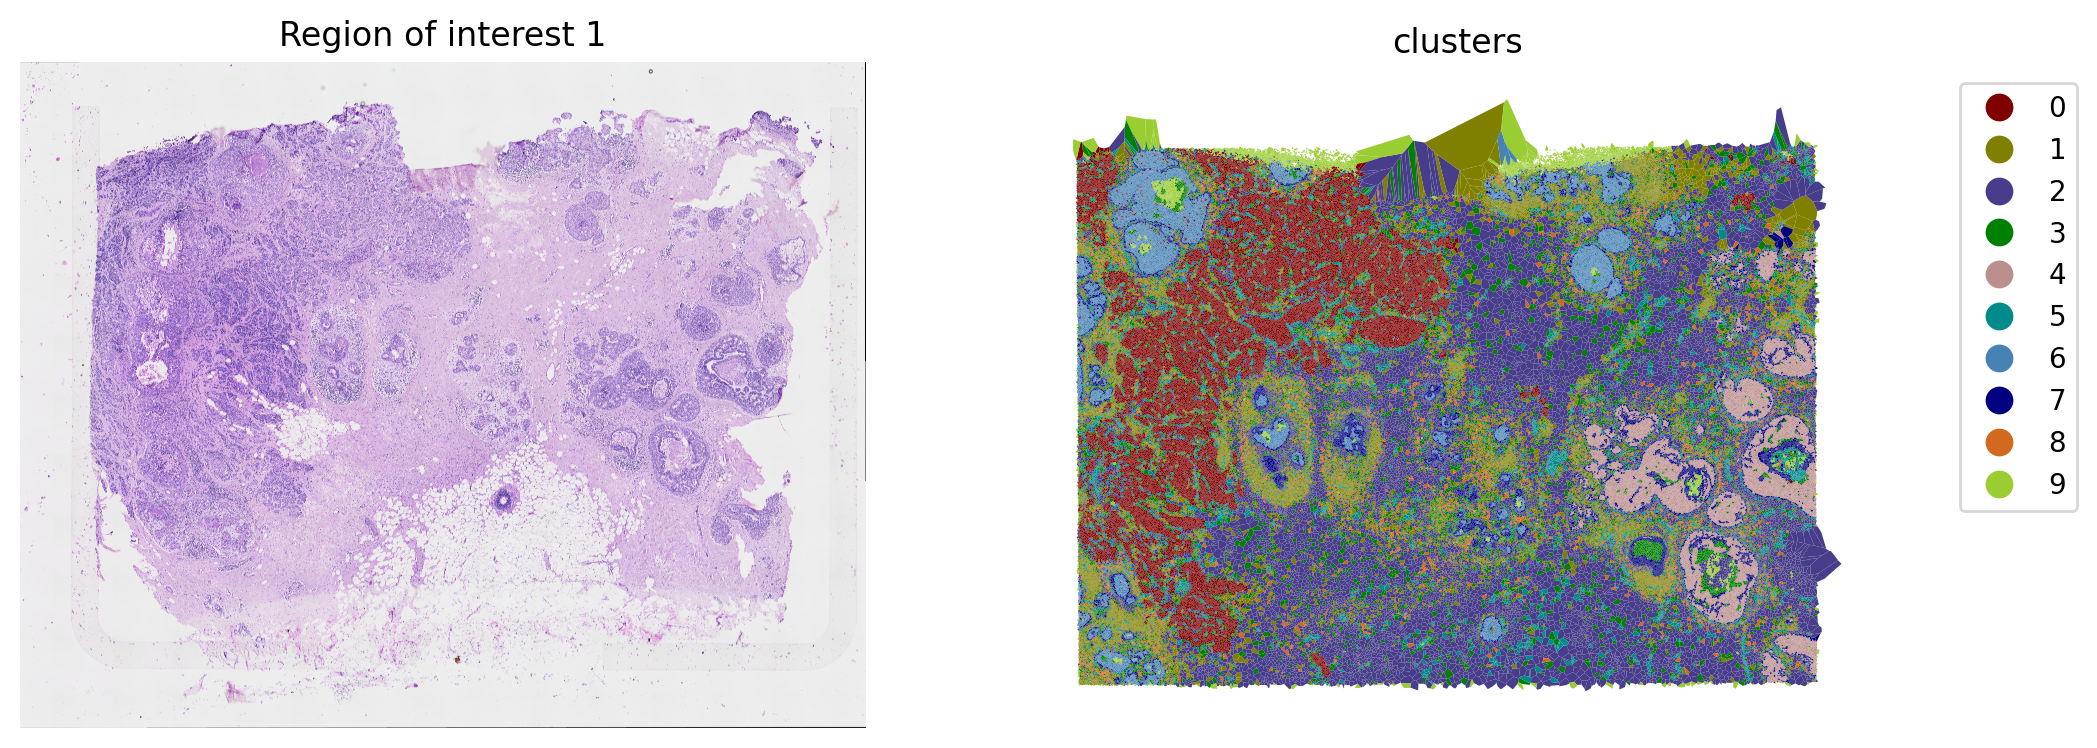

In [39]:
import sys
sys.path.append('../src/utils')
import os
import importlib
import image_plot_utils
importlib.reload(image_plot_utils)
from image_plot_utils import plot_clusters_and_save_image

# Plot and save the clustering results
plot_clusters_and_save_image(title="Region of interest 1", gdf=gdf, img=img, adata=count_area_filtered_adata, color_by_obs='clusters', output_name="image_clustering.ROI1.tiff")

In [40]:
merged_gdf = gdf.merge(count_area_filtered_adata.obs['clusters'].astype('category'), left_on='id', right_index=True)

<Axes: >

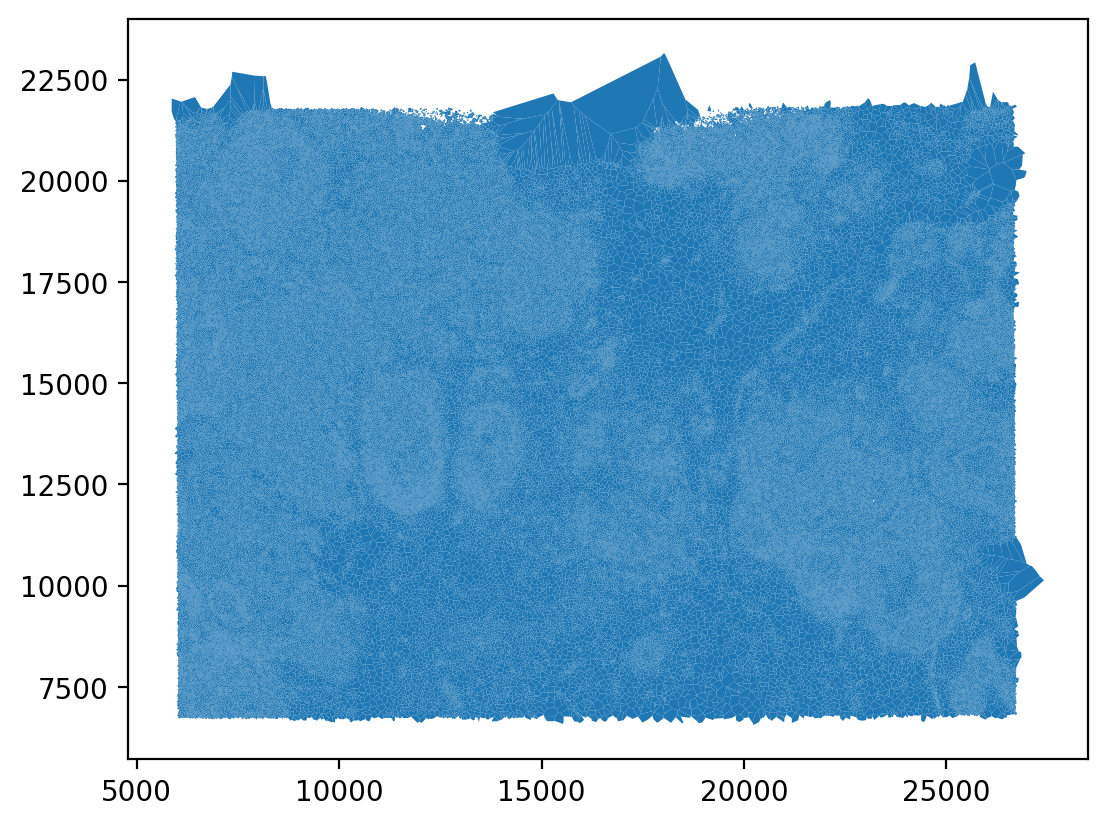

In [42]:
merged_gdf.plot()

In [43]:
merged_gdf_no_clusters = merged_gdf.drop(columns=['clusters'])

In [45]:
import sys
sys.path.append('../src/utils')
import os

# Importing importlib for module reloading
import importlib
import image_cropp_utils

# Reloading the module
importlib.reload(image_cropp_utils)

from image_cropp_utils import load_dataframe

In [46]:
cells_data = load_dataframe('../data/xenium/outs/cells.parquet')

In [47]:
cells_data

cell_id   x_centroid   y_centroid  transcript_counts   
0             1   847.259912   326.191365                 28  \
1             2   826.341995   328.031830                 94   
2             3   848.766919   331.743187                  9   
3             4   824.228409   334.252643                 11   
4             5   841.357538   332.242505                 48   
...         ...          ...          ...                ...   
167775   167776  7455.475342  5114.875415                229   
167776   167777  7483.727051  5111.477490                 79   
167777   167778  7470.159424  5119.132056                397   
167778   167779  7477.737207  5128.712817                117   
167779   167780  7489.376562  5123.197778                378   

        control_probe_counts  control_codeword_counts  total_counts   
0                          1                        0            29  \
1                          0                        0            94   
2                          0                        0             9   
3                          0                        0            11   
4                          0                        0            48   
...                      ...                      ...           ...   
167775                     1                        0           230   
167776                     0                        0            79   
167777                     0                        0           397   
167778                     0                        0           117   
167779                     0                        0           378   

         cell_area  nucleus_area  
0        58.387031     26.642188  
1       197.016719     42.130781  
2        16.256250     12.688906  
3        42.311406     10.069844  
4       107.652500     37.479688  
...            ...           ...  
167775  220.452813     60.599688  
167776   37.389375     25.242344  
167777  287.058281     86.700000  
167778  235.354375     25.197188  
167779  270.079531    111.806875  

[167780 rows x 9 columns]

In [48]:
import numpy as np
transform_matrix = np.array([
    [1.7125010585876286, 0.008345081015717404, -10397.19948741904],
    [0.008345081015717404, -1.7125010585876286, 37211.538978661185],
    [0, 0, 1]
])

# Get the inverse matrix
transform_matrix_inv = np.linalg.inv(transform_matrix)

# Extract coordinates and apply scaling
coords = cells_data[['x_centroid', 'y_centroid']].values
micron_to_pixel = 0.2125  # Microns per pixel
coords_scaled = coords / micron_to_pixel

# Function to transform coordinates
def transform_coordinates(coords, transform_matrix):
    coords = np.hstack((coords, np.ones((len(coords), 1))))
    transformed_coords = np.dot(transform_matrix, coords.T).T
    # Return only the x and y coordinates
    return transformed_coords[:, :2]

# Apply the transformation to the scaled coordinates
transformed_coords = transform_coordinates(coords_scaled, transform_matrix_inv)

# Update the DataFrame with the transformed coordinates
cells_data[['x_location_transformed', 'y_location_transformed']] = transformed_coords

In [49]:
from shapely.geometry import Polygon, Point
# Create a GeoDataFrame from cells_data
geometry = [Point(xy) for xy in zip(cells_data['x_location_transformed'], cells_data['y_location_transformed'])]
cells_gdf = gpd.GeoDataFrame(cells_data, geometry=geometry)
cells_gdf.crs = None

In [50]:
cells_gdf

cell_id   x_centroid   y_centroid  transcript_counts   
0             1   847.259912   326.191365                 28  \
1             2   826.341995   328.031830                 94   
2             3   848.766919   331.743187                  9   
3             4   824.228409   334.252643                 11   
4             5   841.357538   332.242505                 48   
...         ...          ...          ...                ...   
167775   167776  7455.475342  5114.875415                229   
167776   167777  7483.727051  5111.477490                 79   
167777   167778  7470.159424  5119.132056                397   
167778   167779  7477.737207  5128.712817                117   
167779   167780  7489.376562  5123.197778                378   

        control_probe_counts  control_codeword_counts  total_counts   
0                          1                        0            29  \
1                          0                        0            94   
2                          0                        0             9   
3                          0                        0            11   
4                          0                        0            48   
...                      ...                      ...           ...   
167775                     1                        0           230   
167776                     0                        0            79   
167777                     0                        0           397   
167778                     0                        0           117   
167779                     0                        0           378   

         cell_area  nucleus_area  x_location_transformed   
0        58.387031     26.642188             8297.871957  \
1       197.016719     42.130781             8240.416393   
2        16.256250     12.688906             8302.087393   
3        42.311406     10.069844             8234.691783   
4       107.652500     37.479688             8281.733889   
...            ...           ...                     ...   
167775  220.452813     60.599688            26520.667780   
167776   37.389375     25.242344            26598.254969   
167777  287.058281     86.700000            26561.075074   
167778  235.354375     25.197188            26582.026307   
167779  270.079531    111.806875            26613.936167   

        y_location_transformed                    geometry  
0                 20873.427800  POINT (8297.872 20873.428)  
1                 20868.090296  POINT (8240.416 20868.090)  
2                 20858.192164  POINT (8302.087 20858.192)  
3                 20850.967862  POINT (8234.692 20850.968)  
4                 20856.720876  POINT (8281.734 20856.721)  
...                        ...                         ...  
167775             7803.121686  POINT (26520.668 7803.122)  
167776             7812.837128  POINT (26598.255 7812.837)  
167777             7791.621519  POINT (26561.075 7791.622)  
167778             7765.396076  POINT (26582.026 7765.396)  
167779             7780.706674  POINT (26613.936 7780.707)  

[167780 rows x 12 columns]

<Axes: >

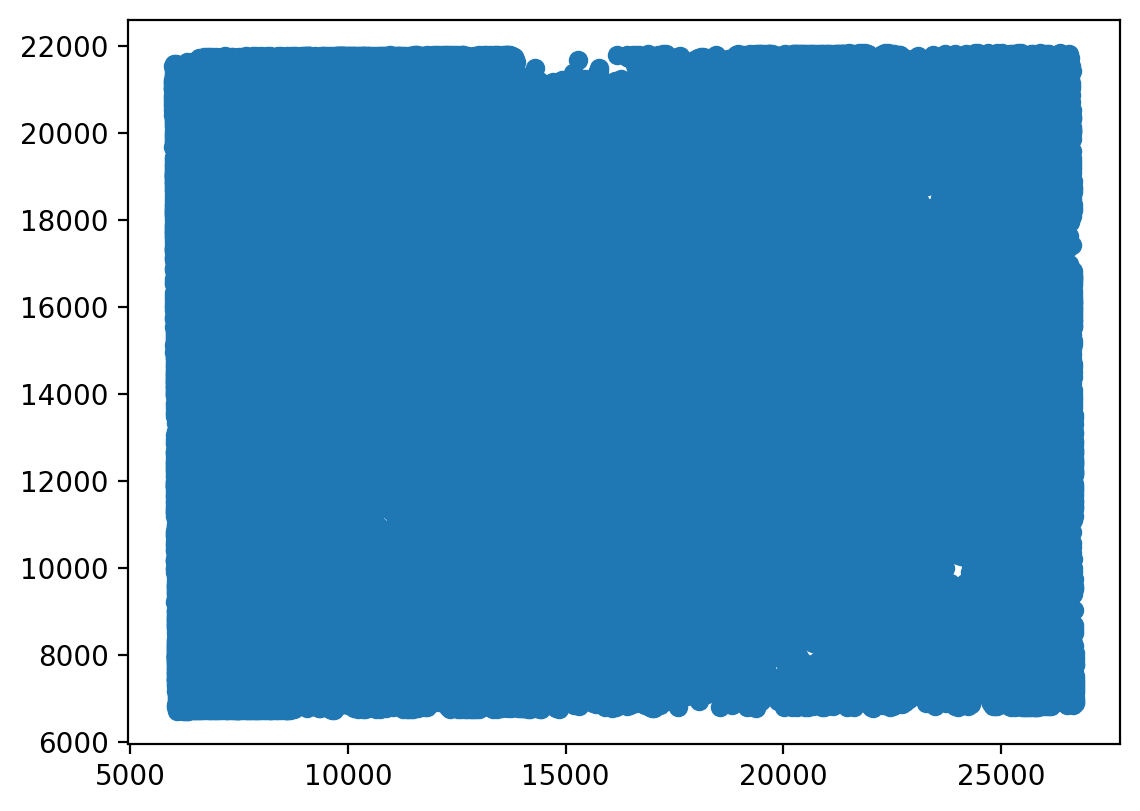

In [51]:
cells_gdf.plot()

In [52]:
# Perform spatial join
joined = gpd.sjoin(merged_gdf_no_clusters, cells_gdf, how='left', predicate='intersects')

<Axes: >

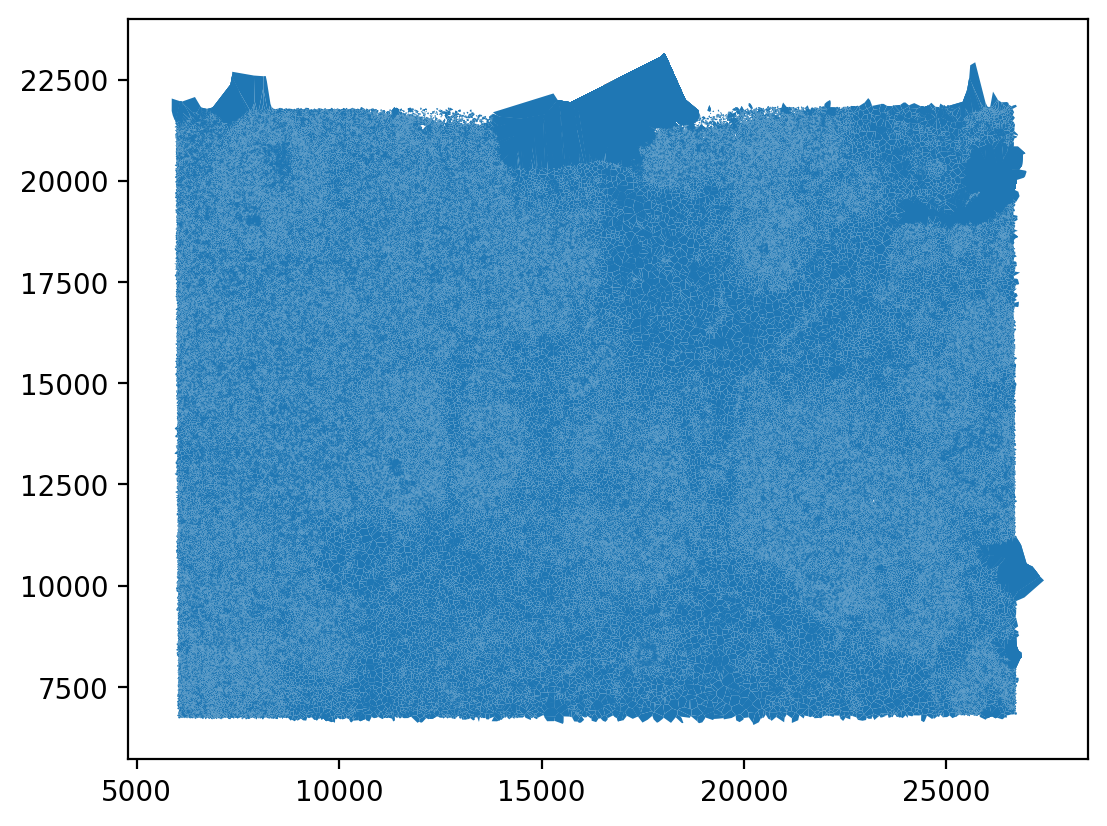

In [53]:
joined.plot()

In [54]:
joined

geometry         id   
6202    POLYGON ((7110.770 6825.238, 7124.374 6854.249...    ID_6203  \
6209    POLYGON ((6279.099 6982.299, 6281.607 6953.524...    ID_6210   
6212    POLYGON ((7193.251 6729.451, 7208.089 6732.524...    ID_6213   
6226    POLYGON ((6454.599 7248.218, 6443.083 7263.338...    ID_6227   
6230    POLYGON ((6907.168 7168.644, 6922.874 7168.744...    ID_6231   
...                                                   ...        ...   
215188  POLYGON ((24366.226 21234.299, 24332.589 21219...  ID_215189   
215189  POLYGON ((25935.394 21766.393, 25909.894 21765...  ID_215190   
215191  POLYGON ((26626.521 21099.852, 26611.965 21188...  ID_215192   
215192  POLYGON ((25655.911 21595.849, 25644.229 21622...  ID_215193   
215194  POLYGON ((24867.454 21126.586, 24805.642 21121...  ID_215195   

        index_right   cell_id   x_centroid   y_centroid  transcript_counts   
6202        42284.0   42285.0   399.355255  5437.458716              592.0  \
6209        42966.0   42967.0    82.964026  5382.626245              173.0   
6212            NaN       NaN          NaN          NaN                NaN   
6226        43061.0   43062.0   145.100730  5281.886304              108.0   
6230        42582.0   42583.0   318.665202  5303.403174              252.0   
...             ...       ...          ...          ...                ...   
215188          NaN       NaN          NaN          NaN                NaN   
215189          NaN       NaN          NaN          NaN                NaN   
215191          NaN       NaN          NaN          NaN                NaN   
215192     151019.0  151020.0  7148.162988    85.906860               88.0   
215194          NaN       NaN          NaN          NaN                NaN   

        control_probe_counts  control_codeword_counts  total_counts   
6202                     0.0                      0.0         592.0  \
6209                     0.0                      0.0         173.0   
6212                     NaN                      NaN           NaN   
6226                     0.0                      0.0         108.0   
6230                     1.0                      0.0         253.0   
...                      ...                      ...           ...   
215188                   NaN                      NaN           NaN   
215189                   NaN                      NaN           NaN   
215191                   NaN                      NaN           NaN   
215192                   0.0                      0.0          88.0   
215194                   NaN                      NaN           NaN   

         cell_area  nucleus_area  x_location_transformed   
6202    398.142656    147.525469             7135.520510  \
6209    179.405781     55.813125             6265.376854   
6212           NaN           NaN                     NaN   
6226    110.632812     36.079844             6434.772936   
6230    150.280000     75.320625             6911.997752   
...            ...           ...                     ...   
215188         NaN           NaN                     NaN   
215189         NaN           NaN                     NaN   
215191         NaN           NaN                     NaN   
215192   77.126875     17.881875            25608.865307   
215194         NaN           NaN                     NaN   

        y_location_transformed  
6202               6822.211526  
6209               6968.648654  
6212                       NaN  
6226               7246.303336  
6230               7189.501397  
...                        ...  
215188                     NaN  
215189                     NaN  
215191                     NaN  
215192            21618.076830  
215194                     NaN  

[184947 rows x 14 columns]

In [55]:
filtered_joined = joined[~joined['index_right'].isna()]

In [56]:
filtered_joined

geometry         id   
6202    POLYGON ((7110.770 6825.238, 7124.374 6854.249...    ID_6203  \
6209    POLYGON ((6279.099 6982.299, 6281.607 6953.524...    ID_6210   
6226    POLYGON ((6454.599 7248.218, 6443.083 7263.338...    ID_6227   
6230    POLYGON ((6907.168 7168.644, 6922.874 7168.744...    ID_6231   
6242    POLYGON ((6197.152 7191.234, 6198.145 7195.513...    ID_6243   
...                                                   ...        ...   
215150  POLYGON ((24644.672 21027.918, 24632.961 21049...  ID_215151   
215161  POLYGON ((24721.273 21834.457, 24626.168 21928...  ID_215162   
215170  POLYGON ((26325.462 21748.073, 26364.109 21918...  ID_215171   
215170  POLYGON ((26325.462 21748.073, 26364.109 21918...  ID_215171   
215192  POLYGON ((25655.911 21595.849, 25644.229 21622...  ID_215193   

        index_right   cell_id   x_centroid   y_centroid  transcript_counts   
6202        42284.0   42285.0   399.355255  5437.458716              592.0  \
6209        42966.0   42967.0    82.964026  5382.626245              173.0   
6226        43061.0   43062.0   145.100730  5281.886304              108.0   
6230        42582.0   42583.0   318.665202  5303.403174              252.0   
6242        43041.0   43042.0    64.706159  5305.564697               97.0   
...             ...       ...          ...          ...                ...   
215150     150706.0  150707.0  6780.770825   316.917836              346.0   
215161      12176.0   12177.0  6817.952515     8.849210               17.0   
215170      12242.0   12243.0  7417.128223    26.647450              269.0   
215170      12241.0   12242.0  7423.180322     9.744251               68.0   
215192     151019.0  151020.0  7148.162988    85.906860               88.0   

        control_probe_counts  control_codeword_counts  total_counts   
6202                     0.0                      0.0         592.0  \
6209                     0.0                      0.0         173.0   
6226                     0.0                      0.0         108.0   
6230                     1.0                      0.0         253.0   
6242                     0.0                      0.0          97.0   
...                      ...                      ...           ...   
215150                   0.0                      0.0         346.0   
215161                   0.0                      0.0          17.0   
215170                   0.0                      0.0         269.0   
215170                   0.0                      0.0          68.0   
215192                   0.0                      0.0          88.0   

         cell_area  nucleus_area  x_location_transformed   
6202    398.142656    147.525469             7135.520510  \
6209    179.405781     55.813125             6265.376854   
6226    110.632812     36.079844             6434.772936   
6230    150.280000     75.320625             6911.997752   
6242    108.962031     28.854844             6214.174281   
...            ...           ...                     ...   
215150  500.376406     28.674219            24602.404125   
215161  520.425781     13.953281            24700.450230   
215170  409.522031      8.037813            26347.159620   
215170  633.813125      9.844062            26363.563802   
215192   77.126875     17.881875            25608.865307   

        y_location_transformed  
6202               6822.211526  
6209               6968.648654  
6226               7246.303336  
6230               7189.501397  
6242               7180.161100  
...                        ...  
215150            20978.363664  
215161            21825.401338  
215170            21784.516984  
215170            21831.046215  
215192            21618.076830  

[166908 rows x 14 columns]

<Axes: >

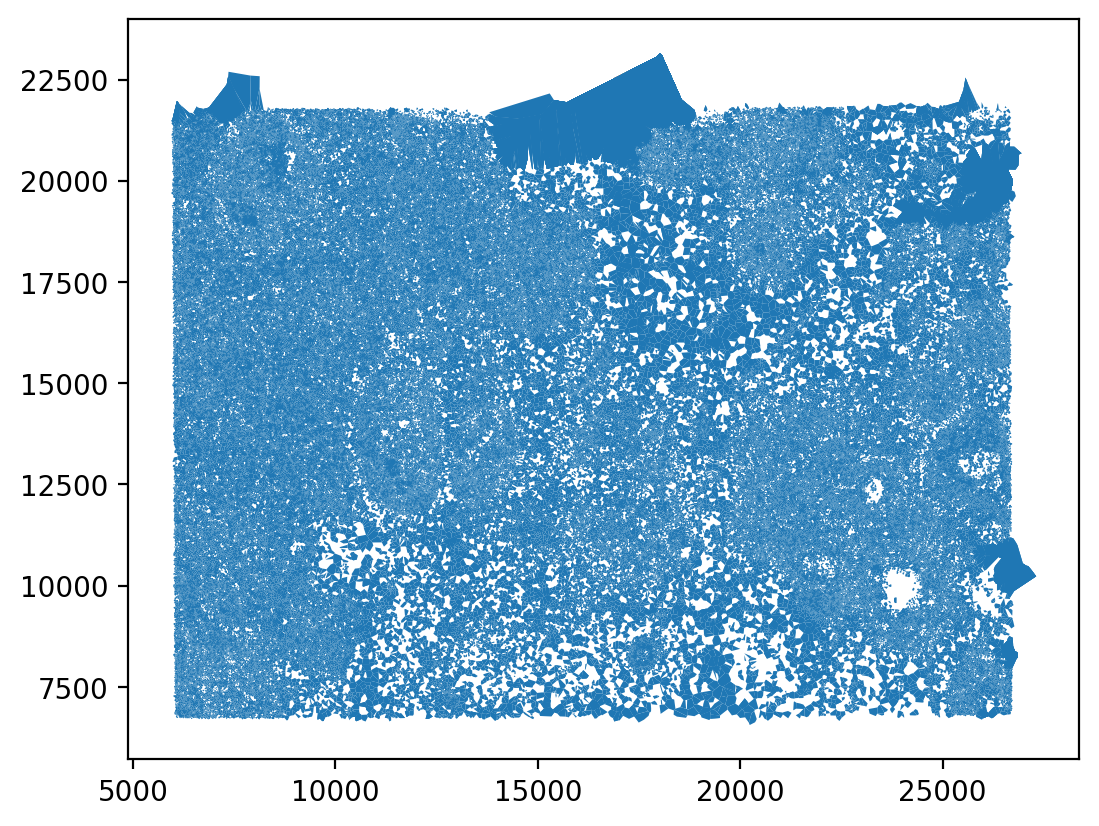

In [57]:
filtered_joined.plot()

In [58]:
import pandas as pd

# Group by 'id' and aggregate 'cell_id' by joining with a comma for duplicates
aggregated_df = filtered_joined.groupby('id').agg({
    'geometry': 'first',  # Keep the first geometry (assuming it's the same for duplicates)
    'cell_id': lambda x: ','.join(x.astype(str))  # Combine cell_id values with a comma
}).reset_index()

aggregated_df

id                                           geometry   cell_id
0       ID_100000  POLYGON ((23417.728 13082.538, 23436.610 13072...  142883.0
1       ID_100001  POLYGON ((22649.140 12853.501, 22644.159 12831...  141638.0
2       ID_100002  POLYGON ((20755.929 12329.609, 20745.389 12354...  133378.0
3       ID_100004  POLYGON ((23155.802 12877.186, 23150.045 12841...  141054.0
4       ID_100006  POLYGON ((22934.109 13176.299, 22932.639 13178...  141241.0
...           ...                                                ...       ...
134073   ID_99993  POLYGON ((22579.117 12805.142, 22573.331 12817...  141635.0
134074   ID_99996  POLYGON ((23150.883 12916.108, 23162.683 12902...  141055.0
134075   ID_99997  POLYGON ((20674.553 11047.656, 20694.762 11038...  134602.0
134076   ID_99998  POLYGON ((22808.541 12187.250, 22797.677 12192...  145875.0
134077   ID_99999  POLYGON ((22168.469 12617.852, 22158.304 12582...  141171.0

[134078 rows x 3 columns]

In [59]:
# Count the number of cell_ids by splitting on the comma and checking the length
aggregated_df['cell_id_count'] = aggregated_df['cell_id'].apply(lambda x: len(x.split(',')))

# Filter the rows where the count of cell_ids is greater than 1
rows_with_multiple_cell_ids = aggregated_df[aggregated_df['cell_id_count'] > 1]

# Count how many such rows exist
num_rows_with_multiple_cell_ids = rows_with_multiple_cell_ids.shape[0]

# Display the result
print(f"Number of rows with more than one cell_id: {num_rows_with_multiple_cell_ids}")


Number of rows with more than one cell_id: 26272


In [60]:
filtered_df = aggregated_df[aggregated_df['cell_id_count'] <= 1]

# Drop the 'cell_id_count' column if you no longer need it
filtered_df = filtered_df.drop(columns=['cell_id_count'])

# Display the resulting DataFrame
filtered_df

id                                           geometry   cell_id
0       ID_100000  POLYGON ((23417.728 13082.538, 23436.610 13072...  142883.0
1       ID_100001  POLYGON ((22649.140 12853.501, 22644.159 12831...  141638.0
2       ID_100002  POLYGON ((20755.929 12329.609, 20745.389 12354...  133378.0
3       ID_100004  POLYGON ((23155.802 12877.186, 23150.045 12841...  141054.0
4       ID_100006  POLYGON ((22934.109 13176.299, 22932.639 13178...  141241.0
...           ...                                                ...       ...
134073   ID_99993  POLYGON ((22579.117 12805.142, 22573.331 12817...  141635.0
134074   ID_99996  POLYGON ((23150.883 12916.108, 23162.683 12902...  141055.0
134075   ID_99997  POLYGON ((20674.553 11047.656, 20694.762 11038...  134602.0
134076   ID_99998  POLYGON ((22808.541 12187.250, 22797.677 12192...  145875.0
134077   ID_99999  POLYGON ((22168.469 12617.852, 22158.304 12582...  141171.0

[107806 rows x 3 columns]

In [61]:
filtered_gdf = gpd.GeoDataFrame(filtered_df, geometry='geometry')

<Axes: >

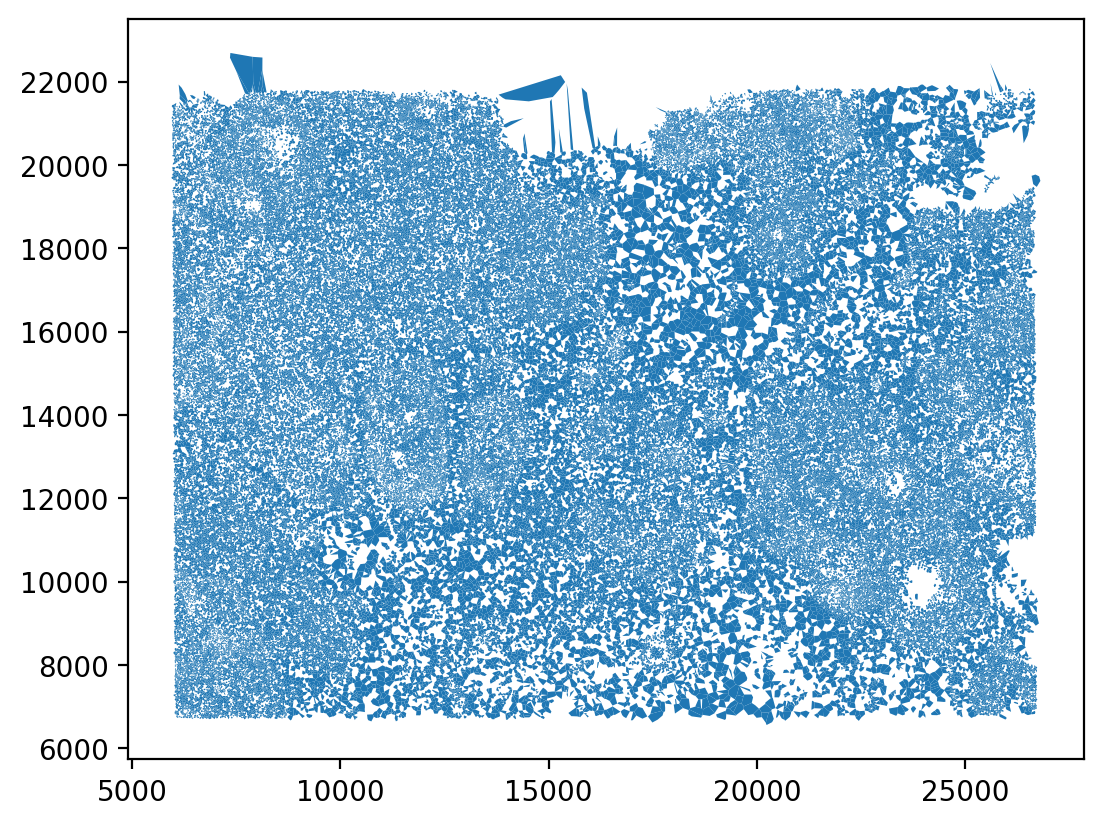

In [62]:
filtered_gdf.plot()

In [63]:
# important use as gdf for id mapping
filtered_gdf.to_file("../data/xenium/outs/final_adatas/filtered_gdf_voronoi.geojson", driver='GeoJSON')

In [64]:
grouped_filtered_adata

AnnData object with n_obs × n_vars = 152117 × 541
    obs: 'id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'clusters'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'clusters'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [65]:
import anndata as ad

# Extract the ids from filtered_gdf
valid_ids = filtered_gdf['id'].tolist()

# Filter the rows in grouped_filtered_adata based on the valid ids
filtered_grouped_adata = grouped_filtered_adata[grouped_filtered_adata.obs['id'].isin(valid_ids)]


In [66]:
filtered_grouped_adata

View of AnnData object with n_obs × n_vars = 107806 × 541
    obs: 'id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'clusters'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'clusters'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [67]:
filtered_grouped_adata.write("../data/xenium/improved_outs/grouped_filtered_voronoi_adata.h5ad")
# IMPORTANT you will need this as ADATA